In [1]:

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
# DATA FILES

price_files = ["bittensor_token_price.csv", "fetchai_token_price.csv",
               "numerai_token_price.csv", "oceanprotocol_token_price.csv",
               "oraichain_token_price.csv", "singularitynet_token_price.csv"]

commits_mapping = {
    "bittensor_commits.json": "TAO",
    "fetchai_commits.json": "FET",
    "numerai_commits.json": "NMR", 
    "oceanprotocol_commits.json": "OCEAN",
    "oraichain_commits.json": "ORAI",
    "singularitynet_commits.json": "AGIX"
}

tokens = ["TAO", "FET", "NMR",
          "OCEAN", "ORAI", "AGIX"]



In [3]:
def get_commits(token, mapping):
    for k, v in mapping.items():
        if token == v:
            filename = f'github_data/{k}'
            with open(filename) as commits_file:
                parsed_json = json.load(commits_file)
            
            commits_rows = [row for sublist in parsed_json for row in sublist]
            commits_df = pd.DataFrame(commits_rows)
            return commits_df
    return f'No commit data for token {token}'

def get_issues(token, mapping):
    for k, v in mapping.items():
        if token == v:
            filename = f'github_data/{k}'
            with open(filename) as issues_files:
                parsed_json = json.load(issues_files)
            
            issues_rows = [row for sublist in parsed_json for row in sublist]
            issues_df = pd.DataFrame(issues_rows)
            return issues_df
    return f'No gh issues data for token {token}'

def load_price_data(token, tokens_list, price_files):
    idx = tokens_list.index(token)
    filename = f'price/{price_files[idx]}'
    return pd.read_csv(filename)



In [4]:
def clean_price_data(price_df):

    price_df['Date'] = pd.to_datetime(price_df['Date'])
    price_df['Year'] = pd.to_datetime(price_df['Date']).dt.year
    price_df['Month'] = pd.to_datetime(price_df['Date']).dt.month
    price_df['Day'] = pd.to_datetime(price_df['Date']).dt.day
    
    useful_columns = ['Date', 'Close', 'Volume', 'Year', 'Month', 'Day']
    price_df = price_df[useful_columns]
    return price_df

def get_commit_trends(commits_df):
    flat_commit = pd.json_normalize(commits_df['commit'])
    commits_df = pd.concat([commits_df, flat_commit], axis=1)
    commits_df.drop(columns=['commit'], inplace=True)

    commits_df['author.date'] = pd.to_datetime(commits_df['author.date']).dt.date

    date_counts = pd.DataFrame()

    date_counts['commit_count'] = commits_df['author.date'].value_counts()

    
    # Reset index to make the date a column
    date_counts = date_counts.reset_index()
    date_counts.columns = ['date', 'commit_count']

    # Convert 'date' column to datetime
    date_counts['date'] = pd.to_datetime(date_counts['date'])
    date_counts['year'] = pd.to_datetime(date_counts['date']).dt.year

    # Set 'date' column as the index
    date_counts.set_index('date', inplace=True)

    # Resample into daily intervals and fill missing dates with zeros
    daily_counts = date_counts.asfreq('D', fill_value=0)

    # Resample into monthly and quarterly intervals
    yearly_counts = date_counts.resample('Y').agg({'commit_count': 'sum', 'year': 'first'})
    monthly_counts = date_counts.resample('M').agg({'commit_count': 'sum', 'year': 'first'})
    weekly_counts = date_counts.resample('W').agg({'commit_count': 'sum', 'year': 'first'})

    return daily_counts, yearly_counts, monthly_counts, weekly_counts

In [5]:
def merging_df(price_df, trend_df, time_frame):
    #Resample data into Weekly data from daily
    temporal_price = price_df.set_index('Date')

    temporal_df = temporal_price.resample(time_frame).agg({'Close': 'last', 'Volume': 'sum', 'Year': 'last', 'Month': 'last', 'Day': 'last'})
    temporal_df.reset_index(inplace=True)

    trend_df.reset_index(inplace=True)
    
    # Set the timeframe for merging
    point0 = trend_df['date'][0]

    price_trend = temporal_df[temporal_df['Date']>=point0]
    price_trend.reset_index(inplace=True, drop=True)

    

    price_trend =  pd.merge(price_trend, trend_df, how='left', left_on='Date', right_on='date')
    price_trend = price_trend[['Date', 'Close', 'Volume', 'Year', 'Month', 'commit_count']]
    return price_trend

In [18]:
def shifted_correlations(df, time_lags, token, time_frame, ax=None):
    correlations = []
    for lag in time_lags:
        # Shift count values by the lag
        shifted_count = df['commit_count'].shift(lag)
        # Calculate correlation between shifted count and closing price
        correlation = df['Close'].corr(shifted_count)
        correlations.append(correlation)
    # Identify optimal time lag
    optimal_lag = time_lags[np.abs(correlations).argmax()]
    print(f'Optimal Time Lag for {token}: {optimal_lag} {time_frame}\n')

    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
    else:
        fig = ax.get_figure()
    
    ax.plot(time_lags, correlations, marker='o')
    ax.set_xlabel(f'Time Lag ({time_frame})')
    ax.set_ylabel('Correlation Coefficient')
    ax.set_title('Correlation Between Closing Price and Count with Time Lag')
    ax.grid(True)
    return ax

Optimal Time Lag for TAO: 4 months

Optimal Time Lag for FET: 3 months

Optimal Time Lag for NMR: 0 months

Optimal Time Lag for OCEAN: 6 months

Optimal Time Lag for ORAI: 8 months

Optimal Time Lag for AGIX: 9 months



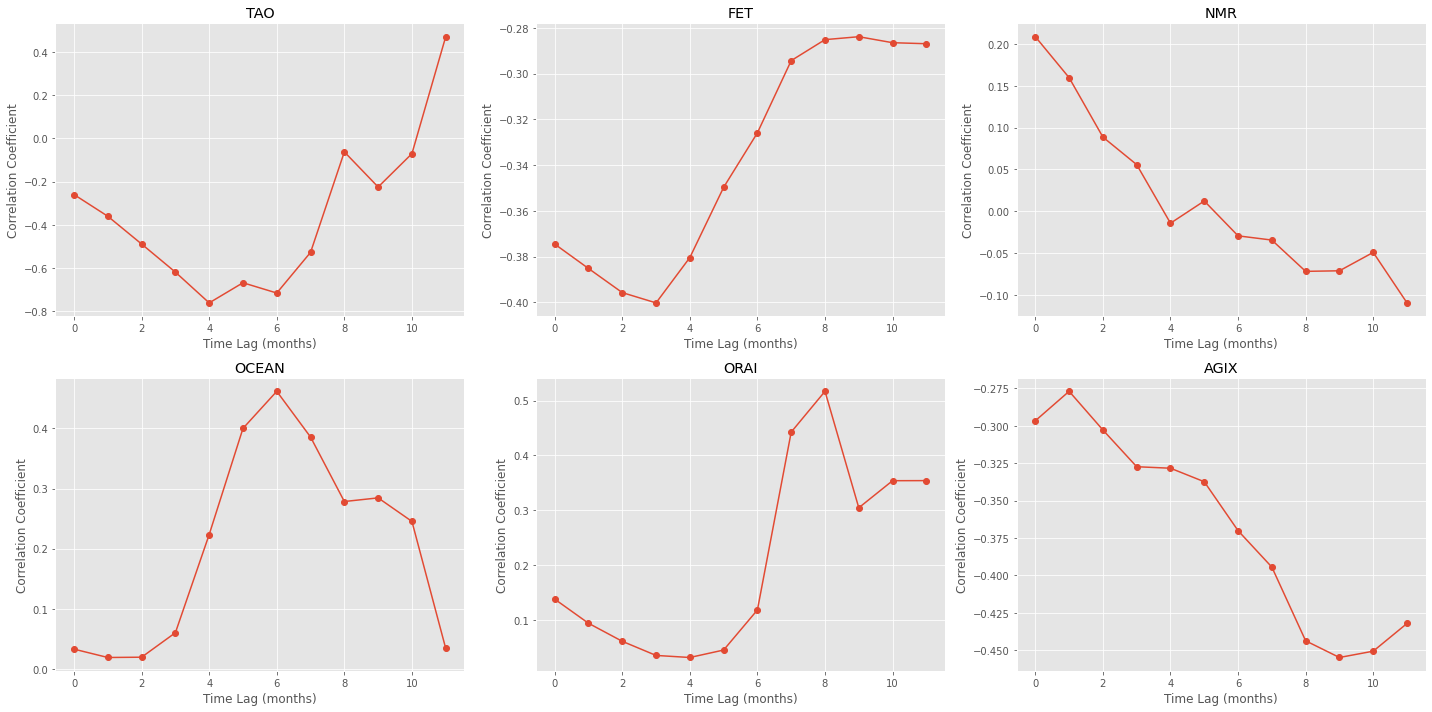

In [19]:
# Define a range of time lags to test
time_lags = range(0, 12)  # Adjust the range as needed

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, token in enumerate(tokens):
    commit_df = get_commits(token, commits_mapping)
    commits_trends = get_commit_trends(commit_df)
    price_df = load_price_data(token, tokens, price_files)
    clean_price = clean_price_data(price_df)
    price_trend_df = merging_df(clean_price, commits_trends[2], 'M')
    ax = axes[i // 3, i % 3]  # Get the appropriate subplot axes
    shifted_correlations(price_trend_df, time_lags, token, 'months', ax=ax)
    ax.set_title(token)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

Optimal Time Lag for TAO: 356 days

Optimal Time Lag for FET: 79 days

Optimal Time Lag for NMR: 4 days

Optimal Time Lag for OCEAN: 174 days

Optimal Time Lag for ORAI: 236 days

Optimal Time Lag for AGIX: 294 days



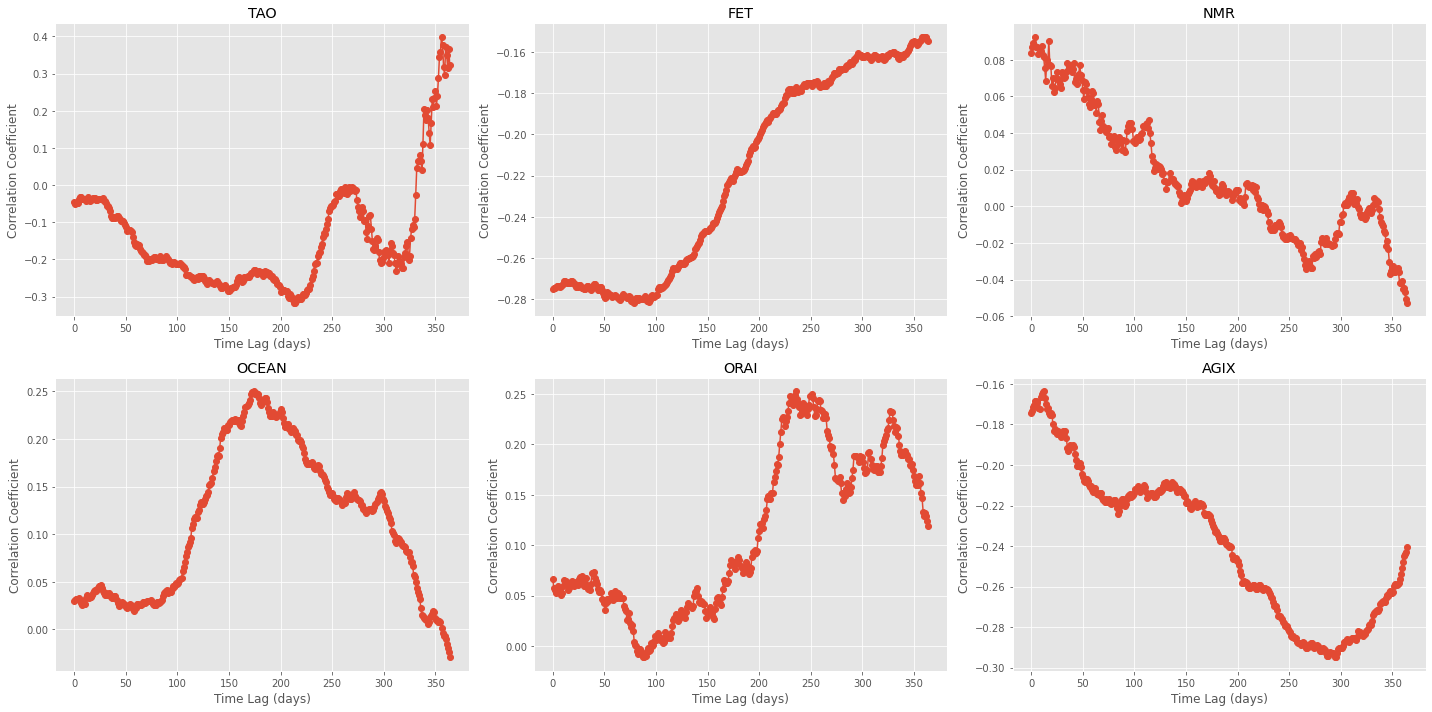

In [20]:
# Define a range of time lags to test: DAILY
time_lags = range(0, 365)  # Adjust the range as needed

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, token in enumerate(tokens):
    commit_df = get_commits(token, commits_mapping)
    commits_trends = get_commit_trends(commit_df)
    price_df = load_price_data(token, tokens, price_files)
    clean_price = clean_price_data(price_df)
    price_trend_df = merging_df(clean_price, commits_trends[0], 'D')
    ax = axes[i // 3, i % 3]  # Get the appropriate subplot axes
    shifted_correlations(price_trend_df, time_lags, token, 'days', ax=ax)
    ax.set_title(token)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

Optimal Time Lag for TAO: 1 years

Optimal Time Lag for FET: 2 years

Optimal Time Lag for NMR: 3 years

Optimal Time Lag for OCEAN: 3 years

Optimal Time Lag for ORAI: 3 years

Optimal Time Lag for AGIX: 1 years



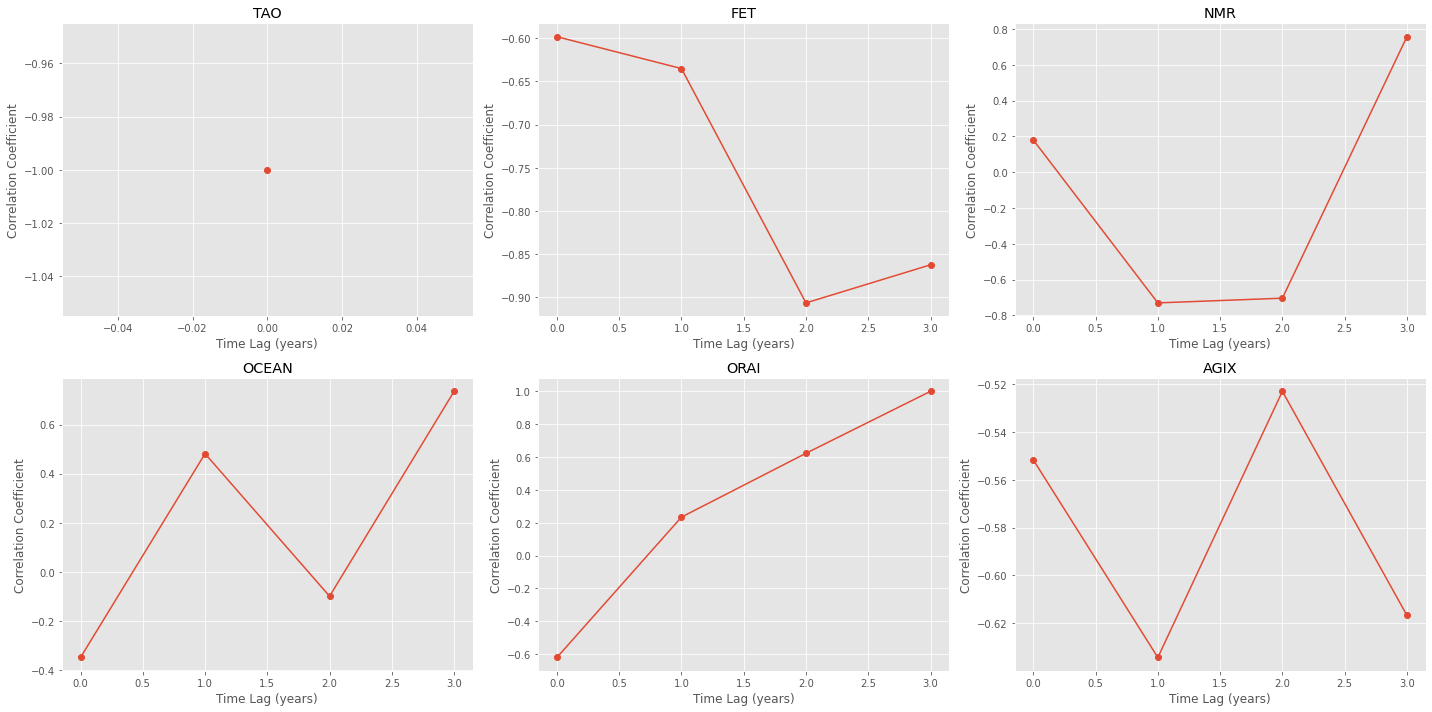

In [22]:
# Define a range of time lags to test: YEARLY
time_lags = range(0, 4)  # Adjust the range as needed

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, token in enumerate(tokens):
    commit_df = get_commits(token, commits_mapping)
    commits_trends = get_commit_trends(commit_df)
    price_df = load_price_data(token, tokens, price_files)
    clean_price = clean_price_data(price_df)
    price_trend_df = merging_df(clean_price, commits_trends[1], 'Y')
    ax = axes[i // 3, i % 3]  # Get the appropriate subplot axes
    shifted_correlations(price_trend_df, time_lags, token, 'years', ax=ax)
    ax.set_title(token)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

Optimal Time Lag for TAO: 51 weeks

Optimal Time Lag for FET: 11 weeks

Optimal Time Lag for NMR: 2 weeks

Optimal Time Lag for OCEAN: 26 weeks

Optimal Time Lag for ORAI: 33 weeks

Optimal Time Lag for AGIX: 41 weeks



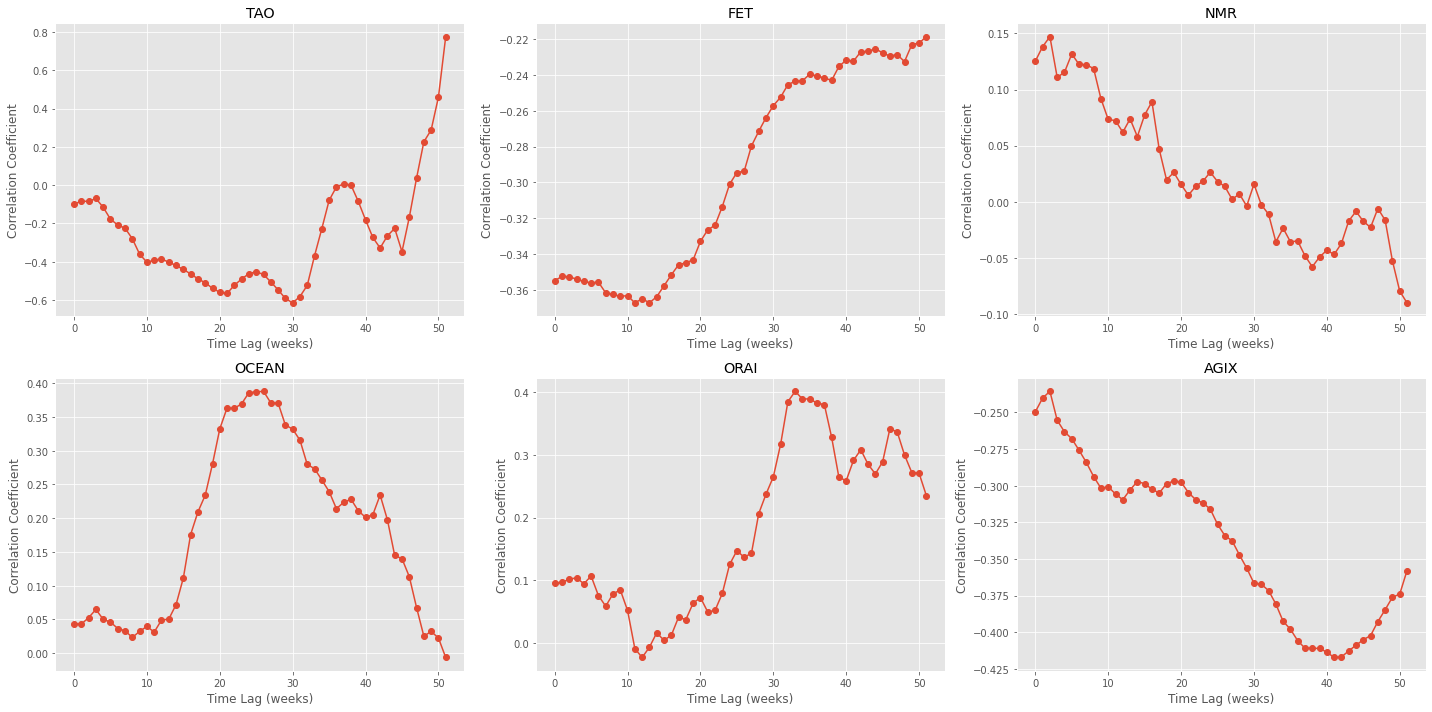

In [23]:
# Define a range of time lags to test: WEEKS
time_lags = range(0, 52)  # Adjust the range as needed

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, token in enumerate(tokens):
    commit_df = get_commits(token, commits_mapping)
    commits_trends = get_commit_trends(commit_df)
    price_df = load_price_data(token, tokens, price_files)
    clean_price = clean_price_data(price_df)
    price_trend_df = merging_df(clean_price, commits_trends[3], 'W')
    ax = axes[i // 3, i % 3]  # Get the appropriate subplot axes
    shifted_correlations(price_trend_df, time_lags, token, 'weeks', ax=ax)
    ax.set_title(token)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()